--- 1. 資料轉換 ---
分類資料集建立完成。

迴歸資料集建立完成。

資料已儲存至 classification_dataset.csv 和 regression_dataset.csv

--- 正在產生資料分佈圖 ---


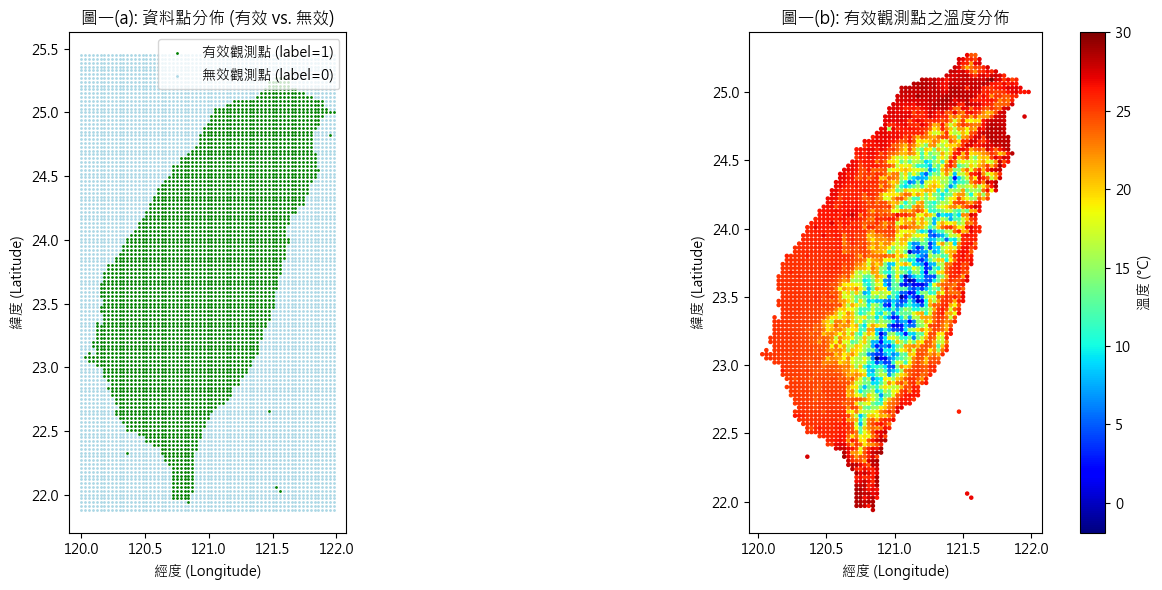


--- 2. 訓練分類模型 (使用 LogisticRegression) ---

分類模型 (LogisticRegression) 訓練完成。

模型評估結果:
準確率 (Accuracy): 0.5653
分類報告 (Classification Report):
               precision    recall  f1-score   support

           0       0.57      1.00      0.72       909
           1       0.00      0.00      0.00       699

    accuracy                           0.57      1608
   macro avg       0.28      0.50      0.36      1608
weighted avg       0.32      0.57      0.41      1608


--- 正在產生分類模型預測結果圖 ---


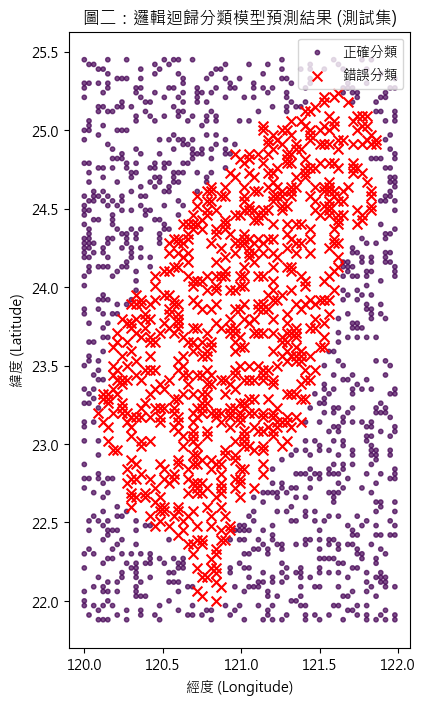


--- 3. 訓練迴歸模型 (使用 LinearRegression) ---

迴歸模型 (LinearRegression) 訓練完成。

模型評估結果:
均方誤差 (Mean Squared Error): 32.1430
R-squared (R²) 分數: 0.0525

--- 正在產生迴歸模型預測結果圖 ---


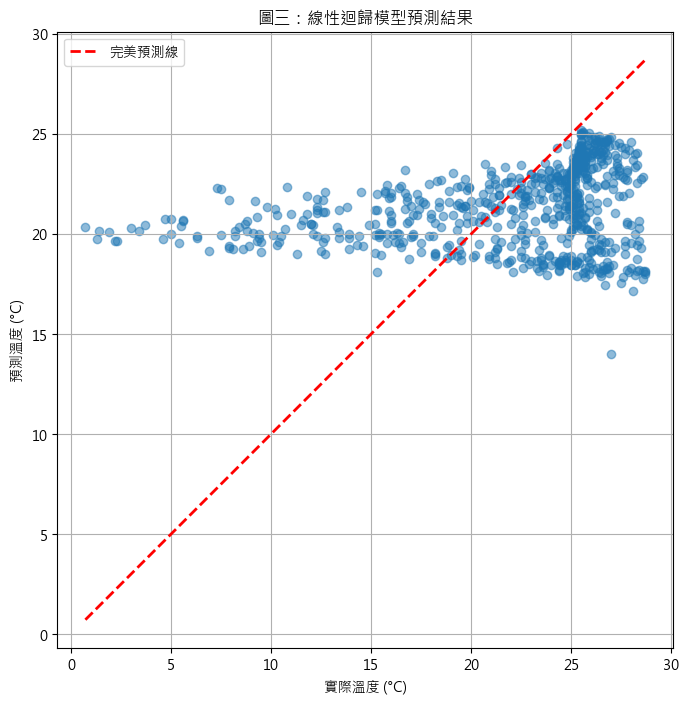

In [11]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score

# 解決 Matplotlib 中文顯示問題
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Heiti TC', 'sans-serif'] # 支援繁體中文
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

def parse_and_transform_data(xml_file_path):
    """
    解析XML氣象資料，並將其轉換為分類和迴歸所需的兩個Pandas DataFrame。
    """
    print("--- 1. 資料轉換 ---")
    
    START_LON = 120.00
    START_LAT = 21.88
    RESOLUTION = 0.03
    LON_POINTS = 67
    LAT_POINTS = 120
    INVALID_VALUE = -999.0

    try:
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        content_element = root.find('.//{urn:cwa:gov:tw:cwacommon:0.1}Content')
        if content_element is None:
            raise ValueError("在XML中找不到 <Content> 標籤。")
        
        raw_data = content_element.text
        normalized_data = raw_data.replace('\n', ' ').replace(',', ' ')
        values = [float(v) for v in normalized_data.split()]
        
        expected_points = LAT_POINTS * LON_POINTS
        if len(values) != expected_points:
            raise ValueError(f"資料點數量不符 ({len(values)} vs {expected_points})，請檢查原始XML檔案格式。")

        grid_data = np.array(values).reshape(LAT_POINTS, LON_POINTS)

    except FileNotFoundError:
        print(f"錯誤：找不到檔案 '{xml_file_path}'。")
        return None, None
    except Exception as e:
        print(f"解析XML時發生錯誤: {e}")
        return None, None

    classification_data = []
    regression_data = []

    for i in range(LAT_POINTS):
        for j in range(LON_POINTS):
            lon = START_LON + j * RESOLUTION
            lat = START_LAT + i * RESOLUTION
            temperature = grid_data[i, j]

            label = 0 if temperature == INVALID_VALUE else 1
            classification_data.append({'longitude': lon, 'latitude': lat, 'label': label})

            if temperature != INVALID_VALUE:
                regression_data.append({'longitude': lon, 'latitude': lat, 'value': temperature})
    
    classification_df = pd.DataFrame(classification_data)
    regression_df = pd.DataFrame(regression_data)

    print("分類資料集建立完成。")
    print("\n迴歸資料集建立完成。")
    classification_df.to_csv("classification_dataset.csv", index=False)
    regression_df.to_csv("regression_dataset.csv", index=False)
    print("\n資料已儲存至 classification_dataset.csv 和 regression_dataset.csv")
    
    return classification_df, regression_df

def visualize_data(classification_df, regression_df):
    """
    將轉換後的資料進行視覺化。
    """
    if classification_df is None or regression_df is None:
        print("資料為空，無法進行視覺化。")
        return

    print("\n--- 正在產生資料分佈圖 ---")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # 子圖一：分類資料集 (有效 vs 無效觀測點)
    valid_points = classification_df[classification_df['label'] == 1]
    invalid_points = classification_df[classification_df['label'] == 0]
    axes[0].scatter(valid_points['longitude'], valid_points['latitude'], s=1, color='green', label='有效觀測點 (label=1)')
    axes[0].scatter(invalid_points['longitude'], invalid_points['latitude'], s=1, color='lightblue', label='無效觀測點 (label=0)')
    axes[0].set_title('圖一(a): 資料點分佈 (有效 vs. 無效)')
    axes[0].set_xlabel('經度 (Longitude)')
    axes[0].set_ylabel('緯度 (Latitude)')
    axes[0].legend()
    axes[0].set_aspect('equal', adjustable='box') # 讓經緯度比例正確

    # 子圖二：迴歸資料集 (溫度分佈)
    scatter = axes[1].scatter(regression_df['longitude'], regression_df['latitude'], c=regression_df['value'], cmap='jet', s=5, label='溫度')
    axes[1].set_title('圖一(b): 有效觀測點之溫度分佈')
    axes[1].set_xlabel('經度 (Longitude)')
    axes[1].set_ylabel('緯度 (Latitude)')
    fig.colorbar(scatter, ax=axes[1], label='溫度 (°C)')
    axes[1].set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.show()

def train_classification_model(df):
    """
    訓練並評估LogisticRegression，並將結果視覺化。
    """
    if df is None or df.empty:
        print("分類資料集為空，跳過模型訓練。")
        return

    print("\n--- 2. 訓練分類模型 (使用 LogisticRegression) ---")
    
    X = df[['longitude', 'latitude']]
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    print("\n分類模型 (LogisticRegression) 訓練完成。")

    y_pred = model.predict(X_test)

    print("\n模型評估結果:")
    print(f"準確率 (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
    print("分類報告 (Classification Report):\n", classification_report(y_test, y_pred, zero_division=0))

    # --- 視覺化分類結果 ---
    print("\n--- 正在產生分類模型預測結果圖 ---")
    plt.figure(figsize=(8, 8))
    misclassified_indices = (y_test != y_pred)
    correct_points = X_test[~misclassified_indices]
    misclassified_points = X_test[misclassified_indices]
    
    plt.scatter(correct_points['longitude'], correct_points['latitude'], c=y_test[~misclassified_indices], cmap='viridis', s=10, label='正確分類', alpha=0.7)
    plt.scatter(misclassified_points['longitude'], misclassified_points['latitude'], c='red', marker='x', s=50, label='錯誤分類')
    
    plt.title('圖二：邏輯迴歸分類模型預測結果 (測試集)')
    plt.xlabel('經度 (Longitude)')
    plt.ylabel('緯度 (Latitude)')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def train_regression_model(df):
    """
    訓練並評估LinearRegression，並將結果視覺化。
    """
    if df is None or df.empty:
        return

    print("\n--- 3. 訓練迴歸模型 (使用 LinearRegression) ---")

    X = df[['longitude', 'latitude']]
    y = df['value']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    print("\n迴歸模型 (LinearRegression) 訓練完成。")
    
    y_pred = model.predict(X_test)

    print("\n模型評估結果:")
    print(f"均方誤差 (Mean Squared Error): {mean_squared_error(y_test, y_pred):.4f}")
    print(f"R-squared (R²) 分數: {r2_score(y_test, y_pred):.4f}")
    
    # --- 視覺化迴歸結果 ---
    print("\n--- 正在產生迴歸模型預測結果圖 ---")
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    # 繪製完美預測線 (y=x)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='完美預測線')
    
    plt.title('圖三：線性迴歸模型預測結果')
    plt.xlabel('實際溫度 (°C)')
    plt.ylabel('預測溫度 (°C)')
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

if __name__ == '__main__':
    XML_FILE = 'O-A0038-003.xml'
    
    classification_df, regression_df = parse_and_transform_data(XML_FILE)
    
    # 步驟一(b)：視覺化原始資料
    visualize_data(classification_df, regression_df)

    # 步驟二：訓練並視覺化分類模型
    train_classification_model(classification_df)
    
    # 步驟三：訓練並視覺化迴歸模型
    train_regression_model(regression_df)




--- 2. 訓練分類模型 (使用 KNeighborsClassifier) ---

分類模型 (KNeighborsClassifier) 訓練完成。

模型評估結果:
準確率 (Accuracy): 0.9888
分類報告 (Classification Report):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       909
           1       0.98      0.99      0.99       699

    accuracy                           0.99      1608
   macro avg       0.99      0.99      0.99      1608
weighted avg       0.99      0.99      0.99      1608


--- 正在產生分類模型預測結果圖 ---


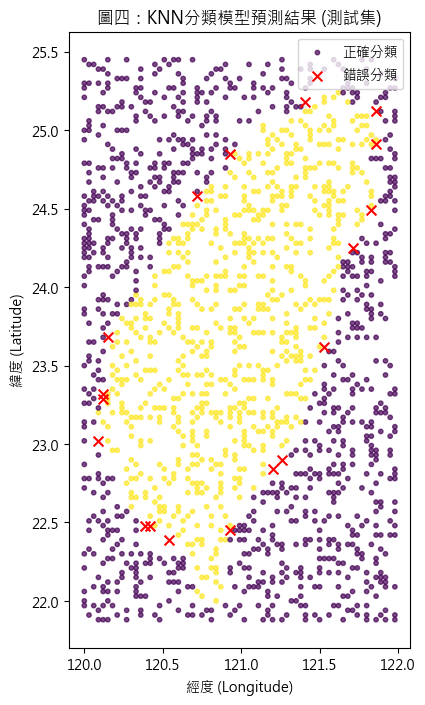


--- 3. 訓練迴歸模型 (使用 KNeighborsRegressor) ---

迴歸模型 (KNeighborsRegressor) 訓練完成。

模型評估結果:
均方誤差 (Mean Squared Error): 4.4453
R-squared (R²) 分數: 0.8690

--- 正在產生迴歸模型預測結果圖 ---


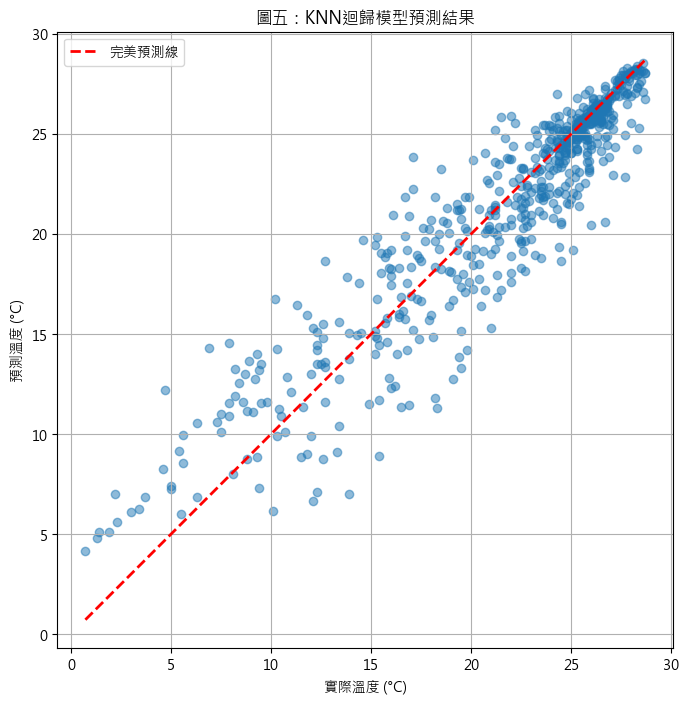

In [12]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score

# 解決 Matplotlib 中文顯示問題
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Heiti TC', 'sans-serif'] # 支援繁體中文
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


def train_classification_model(df):
    """
    訓練並評估KNeighborsClassifier，並將結果視覺化。
    """
    if df is None or df.empty:
        print("分類資料集為空，跳過模型訓練。")
        return

    print("\n--- 2. 訓練分類模型 (使用 KNeighborsClassifier) ---")
    
    X = df[['longitude', 'latitude']]
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    print("\n分類模型 (KNeighborsClassifier) 訓練完成。")

    y_pred = model.predict(X_test)

    print("\n模型評估結果:")
    print(f"準確率 (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
    print("分類報告 (Classification Report):\n", classification_report(y_test, y_pred))

    # --- 視覺化分類結果 ---
    print("\n--- 正在產生分類模型預測結果圖 ---")
    plt.figure(figsize=(8, 8))
    misclassified_indices = (y_test != y_pred)
    correct_points = X_test[~misclassified_indices]
    misclassified_points = X_test[misclassified_indices]
    
    plt.scatter(correct_points['longitude'], correct_points['latitude'], c=y_test[~misclassified_indices], cmap='viridis', s=10, label='正確分類', alpha=0.7)
    plt.scatter(misclassified_points['longitude'], misclassified_points['latitude'], c='red', marker='x', s=50, label='錯誤分類')
    
    plt.title('圖四：KNN分類模型預測結果 (測試集)')
    plt.xlabel('經度 (Longitude)')
    plt.ylabel('緯度 (Latitude)')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def train_regression_model(df):
    """
    訓練並評估KNeighborsRegressor，並將結果視覺化。
    """
    if df is None or df.empty:
        return

    print("\n--- 3. 訓練迴歸模型 (使用 KNeighborsRegressor) ---")

    X = df[['longitude', 'latitude']]
    y = df['value']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)
    print("\n迴歸模型 (KNeighborsRegressor) 訓練完成。")
    
    y_pred = model.predict(X_test)

    print("\n模型評估結果:")
    print(f"均方誤差 (Mean Squared Error): {mean_squared_error(y_test, y_pred):.4f}")
    print(f"R-squared (R²) 分數: {r2_score(y_test, y_pred):.4f}")
    
    # --- 視覺化迴歸結果 ---
    print("\n--- 正在產生迴歸模型預測結果圖 ---")
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    # 繪製完美預測線 (y=x)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='完美預測線')
    
    plt.title('圖五：KNN迴歸模型預測結果')
    plt.xlabel('實際溫度 (°C)')
    plt.ylabel('預測溫度 (°C)')
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

if __name__ == '__main__':
    
    train_classification_model(classification_df)
    
    train_regression_model(regression_df)
